In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial

In [2]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(2, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1)
        
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        activation = nn.SiLU()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [4]:
# 1. FIXME -- training data
x1d=torch.linspace(-1,1,50,requires_grad=True)
t1d=torch.linspace(0,1,50,requires_grad=True)
tgrid,xgrid = torch.meshgrid(t1d,x1d)
t=tgrid.flatten().unsqueeze(-1)
x=xgrid.flatten().unsqueeze(-1)

# 2. set the model
torch.manual_seed(23939)
model = ffnn(32, 2)

# 3. set the optimizer
lr = 0.0001
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 100000
mse_loss = nn.MSELoss()
loss_history = []

# 4. FIXME -- set the loss for BC, IC, and the residual
def loss_function(model,x,t):
  v=model(x,t)
  
  v_x_1= model(x,torch.ones_like(x))

  loss_v_1= mse_loss(v_x_1, x**2)

  v_t = torch.autograd.grad(v,t,grad_outputs=torch.ones_like(t),retain_graph=True,create_graph=True)[0]
  v_x = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(x),retain_graph=True,create_graph=True)[0]

  r= -v_t - x * v_x + 0.25* v_x**2
  loss_r = (r**2).mean()
  loss_value = 100*loss_v_1+ loss_r

  return loss_value

In [5]:
for i in range(n_epochs):
  loss=loss_function(model, x, t)
  opt.zero_grad()
  loss_history.append(loss.item())
  loss.backward()
  opt.step()
  if i % 1000 == 0:
    print(f'epoch {i}, loss = {loss}')

epoch 0, loss = 33.39585876464844
epoch 1000, loss = 6.484857559204102
epoch 2000, loss = 0.15996351838111877
epoch 3000, loss = 0.10346507281064987
epoch 4000, loss = 0.08326354622840881
epoch 5000, loss = 0.06593512743711472
epoch 6000, loss = 0.042120471596717834
epoch 7000, loss = 0.02147897146642208
epoch 8000, loss = 0.010180814191699028
epoch 9000, loss = 0.004435557872056961
epoch 10000, loss = 0.0036254830192774534
epoch 11000, loss = 0.0028802428860217333
epoch 12000, loss = 0.0019302730215713382
epoch 13000, loss = 0.0010198222007602453
epoch 14000, loss = 0.0005003848345950246
epoch 15000, loss = 0.00027740446967072785
epoch 16000, loss = 0.00019249346223659813
epoch 17000, loss = 0.00015634659212082624
epoch 18000, loss = 0.00013804211630485952
epoch 19000, loss = 0.00012807789607904851
epoch 20000, loss = 0.00012175225128885359
epoch 21000, loss = 0.00011588219786062837
epoch 22000, loss = 0.00011112682841485366
epoch 23000, loss = 0.00010716935503296554
epoch 24000, loss

# Plot the solution

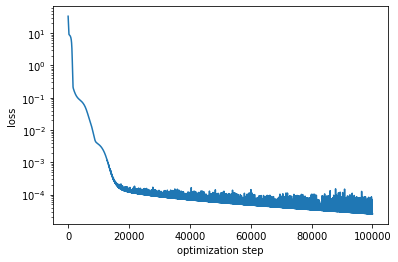

In [6]:
plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss');
plt.yscale('log')

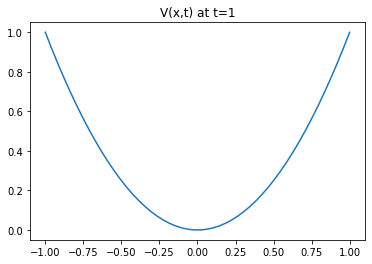

In [7]:
%matplotlib inline
v_x1=model(x1d.unsqueeze(-1),torch.ones_like(x1d.unsqueeze(-1))).detach().numpy().squeeze()
x_values= x1d.detach().numpy().squeeze()
plt.figure()
plt.plot(x_values,v_x1)
plt.title("V(x,t) at t=1")
plt.show()


In [8]:
def v_true(x,t):

  return (2*x**2)/(1+np.exp(2*(t-1)))

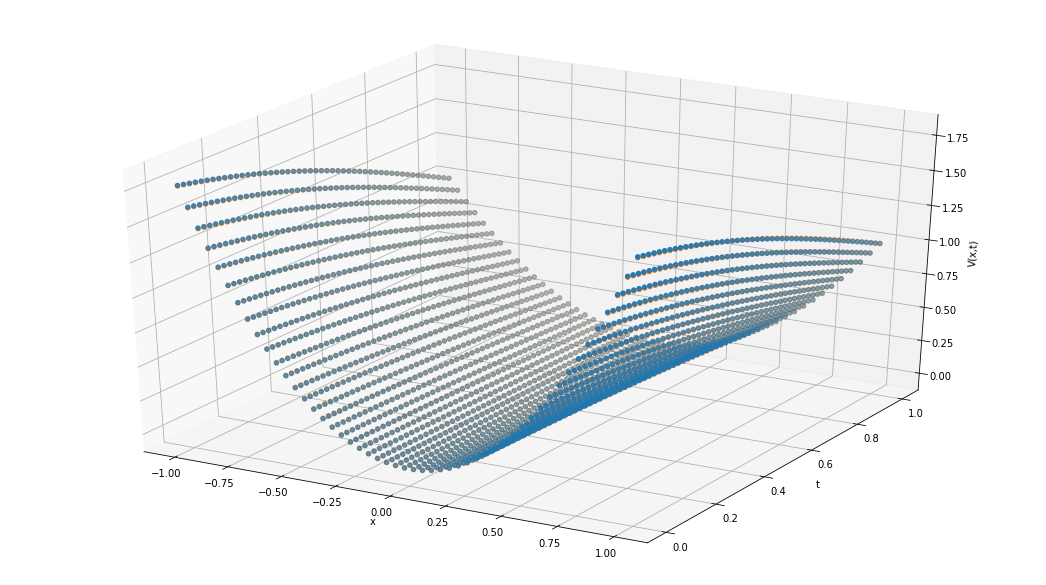

In [9]:
v_x_t = model(x,t).detach().numpy().squeeze().reshape(50,50)
grid_x = xgrid.detach().numpy().squeeze()
grid_t = tgrid.detach().numpy().squeeze()

%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(grid_x, grid_t, v_x_t, cmap='binary')
ax.scatter3D(grid_x, grid_t, v_true(grid_x,grid_t), cmap='binary')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('V(x,t)');
fig.set_size_inches(18.5, 10.5)


In [10]:
from matplotlib import cm
cmap = cm.coolwarm

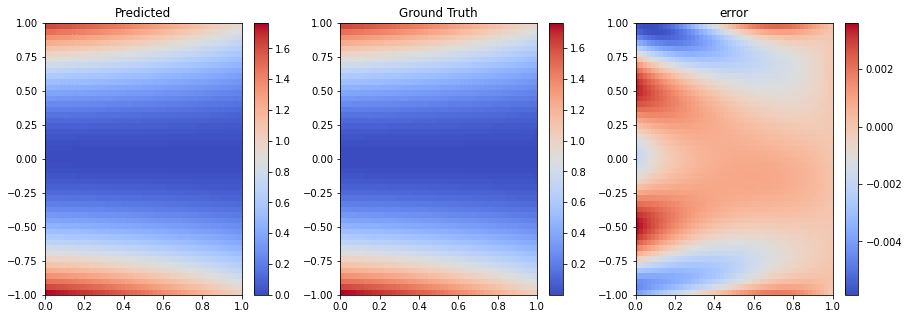

In [11]:
v_actual=v_true(grid_x,grid_t)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
c1=plt.pcolormesh(grid_t,grid_x,v_x_t,cmap=cmap)
plt.colorbar(c1)
plt.title("Predicted")

plt.subplot(1,3,2)
c2=plt.pcolormesh(grid_t,grid_x,v_true(grid_x,grid_t),cmap=cmap)
plt.colorbar(c2)
plt.title("Ground Truth")

plt.subplot(1,3,3)
c3=plt.pcolormesh(grid_t,grid_x,v_actual-v_x_t,cmap=cmap)
plt.colorbar(c3)
plt.title("error")
plt.show()

In [12]:
def u(model,x,t):
  v=model(x,t)
  v_x = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(x),retain_graph=True,create_graph=True)[0]
  return -0.5*v_x

def u_true(x,t):

  return (-2*x)/(1+np.exp(2*(t-1)))

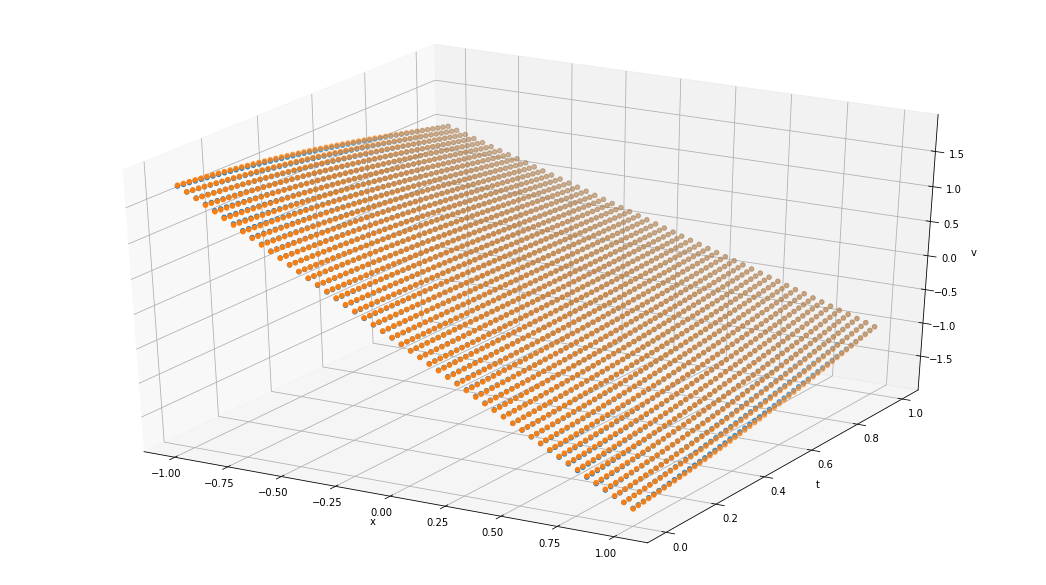

In [13]:
u_x_t = u(model,x,t).detach().numpy().squeeze().reshape(50,50)
grid_x = xgrid.detach().numpy().squeeze()
grid_t = tgrid.detach().numpy().squeeze()

%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(grid_x, grid_t, u_x_t, cmap='binary')
ax.scatter3D(grid_x, grid_t, u_true(grid_x,grid_t), cmap='binary')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('v');
fig.set_size_inches(18.5, 10.5)

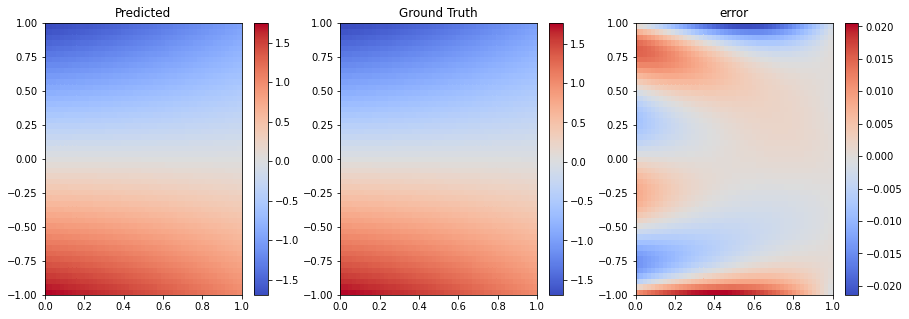

In [17]:
u_actual=u_true(grid_x,grid_t)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
c1=plt.pcolormesh(grid_t,grid_x,u_x_t, cmap=cmap)
plt.colorbar(c1)
plt.title("Predicted")

plt.subplot(1,3,2)
c2=plt.pcolormesh(grid_t,grid_x,u_true(grid_x,grid_t),cmap=cmap)
plt.colorbar(c2)
plt.title("Ground Truth")

plt.subplot(1,3,3)
c3=plt.pcolormesh(grid_t,grid_x,u_actual-u_x_t,cmap=cmap)
plt.colorbar(c3)
plt.title("error")
plt.show()

In [15]:
x_init= torch.tensor([-1],requires_grad=True,dtype=torch.float32).unsqueeze(-1)

x=x_init
states=[x.detach().numpy().squeeze()]
dt = (t1d[1]-t1d[0]).detach()
for t in t1d:
  
  del_x= x + u(model,x, t.view(1,1))
  x=x + del_x*dt
  states.append(x.detach().numpy().squeeze())
  


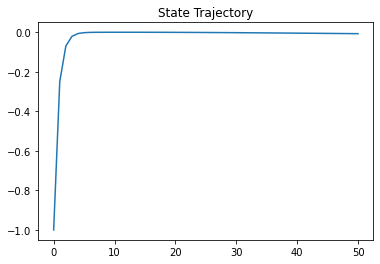

In [16]:
plt.plot(states)
plt.title("State Trajectory")
plt.show()